In [6]:
import pandas as pd
import yfinance as yf

# Parameters
stock_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-01-01'
initial_capital = 5000

# Get historical stock data
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Calculate features for decision tree (optional)
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()

# Calculate daily returns and cumulative returns
data['DailyReturns'] = data['Close'].pct_change()
data['CumulativeReturns'] = (1 + data['DailyReturns']).cumprod()

# Calculate shares bought with initial capital
data['SharesBought'] = initial_capital / data['Close'].iloc[0]
data['ShareValue'] = data['SharesBought'] * data['Close']

# Print final share value
final_share_value = data['ShareValue'].iloc[-1]
print(f"Final Share Value: ${final_share_value:.2f}")


[*********************100%***********************]  1 of 1 completed
Final Share Value: $8651.91


In [13]:
import pandas as pd
import yfinance as yf
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Parameters
stock_symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-01-01'
initial_capital = 5000
transaction_cost_percentage = 0 # 0.1%
slippage_percentage = 0  # 0.5%

# Get historical stock data
data = yf.download(stock_symbol, start=start_date, end=end_date)

# Calculate additional indicators: RSI and MACD
data['RSI'] = talib.RSI(data['Close'], timeperiod=14)
data['MACD'], data['SignalLine'], _ = talib.MACD(data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)

# Calculate features for decision tree
data['SMA50'] = data['Close'].rolling(window=50).mean()
data['SMA200'] = data['Close'].rolling(window=200).mean()
data['Signal'] = 0
data.loc[(data['SMA50'] > data['SMA200']) & (data['RSI'] < 70) & (data['MACD'] > 0), 'Signal'] = 1
data.loc[(data['SMA50'] < data['SMA200']) & (data['RSI'] > 30) & (data['MACD'] < 0), 'Signal'] = -1

# Prepare data for classification
data.dropna(inplace=True)
X = data[['SMA50', 'SMA200', 'RSI', 'MACD']]
y = data['Signal']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.2f}")

# Backtesting using predicted signals
data['PredictedSignal'] = clf.predict(X)
data['Position'] = data['PredictedSignal'].shift(1)
data['Position'].fillna(0, inplace=True)
data['DailyReturns'] = data['Position'] * data['Close'].pct_change()

# Calculate transaction costs and slippage
data['TransactionCosts'] = abs(data['Position'].diff()) * data['Close'] * transaction_cost_percentage
data['Slippage'] = abs(data['Position'].diff()) * data['Close'] * slippage_percentage

# Adjust daily returns for costs and slippage
data['AdjustedDailyReturns'] = data['DailyReturns'] - data['TransactionCosts'] - data['Slippage']

# Calculate cumulative returns with adjusted returns
data['CumulativeAdjustedReturns'] = (1 + data['AdjustedDailyReturns']).cumprod()
data['PortfolioValueAdjusted'] = initial_capital * (1 + data['AdjustedDailyReturns']).cumprod()

# Print final portfolio value with adjustments
final_portfolio_value_adjusted = data['PortfolioValueAdjusted'].iloc[-1]
print(f"Final Portfolio Value (with Costs and Slippage): ${final_portfolio_value_adjusted:.2f}")


[*********************100%***********************]  1 of 1 completed
Decision Tree Accuracy: 1.00
Final Portfolio Value (with Costs and Slippage): $5158.02


In [18]:
import yfinance as yf
from textblob import TextBlob
import requests

# Fetch stock data using yfinance
stock_symbol = "AAPL"
stock_data = yf.download(stock_symbol, period="1d")

# Fetch recent Reddit posts about stocks (using Pushshift API)
reddit_url = "https://api.pushshift.io/reddit/search/submission/"
params = {
    "q": "stock market",
    "subreddit": "stocks",
    "size": 10,
    "sort": "desc",
    "sort_type": "created_utc"
}
reddit_posts = requests.get(reddit_url, params=params).json()["data"]

# Analyze sentiment of Reddit post titles
positive_sentiment_count = 0
negative_sentiment_count = 0
neutral_sentiment_count = 0

for post in reddit_posts:
    title = post["title"]
    analysis = TextBlob(title)
    if analysis.sentiment.polarity > 0:
        positive_sentiment_count += 1
    elif analysis.sentiment.polarity < 0:
        negative_sentiment_count += 1
    else:
        neutral_sentiment_count += 1

# Determine trending stock based on sentiment and other factors
# You might want to use more sophisticated methods for this step

# Display results
print("Positive Sentiment Count:", positive_sentiment_count)
print("Negative Sentiment Count:", negative_sentiment_count)
print("Neutral Sentiment Count:", neutral_sentiment_count)


[*********************100%***********************]  1 of 1 completed


KeyError: 'data'

In [22]:
import requests
from bs4 import BeautifulSoup

def get_trending_stocks():
    url = "https://www.cnbc.com/"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    
    trending_stocks = []
    
    for headline in soup.find_all('h3', class_='Card-title'):
        stock_name = headline.get_text()
        trending_stocks.append(stock_name)
    
    return trending_stocks

if __name__ == "__main__":
    trending_stocks = get_trending_stocks()
    if trending_stocks:
        print("Trending Stocks:")
        for idx, stock in enumerate(trending_stocks, start=1):
            print(f"{idx}. {stock}")
    else:
        print("No trending stocks found.")


No trending stocks found.


In [4]:
import praw
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    if sentiment_scores['compound'] > 0.05:
        return "Positive"
    elif sentiment_scores['compound'] < -0.05:
        return "Negative"
    else:
        return "Neutral"

def get_reddit_posts(subreddit_name, keyword, count=10):
    reddit = praw.Reddit(
        client_id="oZq3D_91AVpErPTYUpO11g",
        client_secret="4blORyBQOKeJNCSpAHyUONrUkIS9Wg",
        user_agent="linux:com.example.stockapp:v1.0 (by /u/Visual-Training2195)"
    )

    subreddit = reddit.subreddit(subreddit_name)
    posts = []

    for submission in subreddit.search(keyword, limit=count):
        posts.append(submission.title)
    
    return posts

if __name__ == "__main__":
    subreddit_name = "stocks"  # Replace with the subreddit you want to search
    keyword = "AAPL"   # Replace with your desired keyword
    post_count = 10

    posts = get_reddit_posts(subreddit_name, keyword, post_count)
    
    if posts:
        print(f"Analyzing sentiment for {post_count} posts related to '{keyword}' on Reddit's r/{subreddit_name}:\n")
        for idx, post in enumerate(posts, start=1):
            sentiment = analyze_sentiment(post)
            print(f"Post {idx}: {post}\nSentiment: {sentiment}\n")
    else:
        print("No posts found.")


Analyzing sentiment for 10 posts related to 'AAPL' on Reddit's r/stocks:

Post 1: Does anyone think AAPL is a buy now?
Sentiment: Neutral

Post 2: Intel $INTC earnings beat expectations which is good news for Apple $AAPL, Qualcomm $QCOM, and AMD $AMD
Sentiment: Positive

Post 3: AAPL stock continues climb to $3T with new trading highs
Sentiment: Neutral

Post 4: AAPL reaches all time high in pre-market trading
Sentiment: Positive

Post 5: AAPL price dump after VR headset reveal
Sentiment: Negative

Post 6: would like an opinion on selling AAPL/MSFT shares
Sentiment: Positive

Post 7: $AAPL where does it go second quarter? Warren Buffett continues to love it. $BRK.B
Sentiment: Positive

Post 8: $AAPL - more room to grow?
Sentiment: Neutral

Post 9: AAPL earnings release bear case : MSFT missed big time on the Hardware part.
Sentiment: Negative

Post 10: Will aapl ever go under $150 again?
Sentiment: Neutral



In [19]:
import praw
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime, timedelta

one_day_ago = datetime.utcnow() - timedelta(days=5)

def analyze_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_scores = analyzer.polarity_scores(text)
    if sentiment_scores['compound'] > 0.05:
        return "Positive"
    elif sentiment_scores['compound'] < -0.05:
        return "Negative"
    else:
        return "Neutral"
# reddit = praw.Reddit(
#     client_id="oZq3D_91AVpErPTYUpO11g",
#     client_secret="4blORyBQOKeJNCSpAHyUONrUkIS9Wg",
#     user_agent="linux:com.example.stockapp:v1.0 (by /u/Visual-Training2195)"
# )

def get_reddit_posts(subreddit_name, keyword, count=10):
    subreddit = reddit.subreddit(subreddit_name)
    posts = []

    for submission in subreddit.search(keyword):#, limit=count):
        post_datetime = datetime.utcfromtimestamp(submission.created_utc)
        # import ipdb;ipdb.set_trace()
        if post_datetime < one_day_ago:
            continue
        posts.append(submission.title)
        
    return posts

if __name__ == "__main__":
    names = ["WallStreetBets","Investing","Dividends","Cryptocurrency","Investing_Discussion"]  # Replace with the subreddit you want to search
    subreddit_names = ['+'.join(names)]
    keywords = ["'$GRAB'","$AAPL","$TSLA","$OTLY","$META"]   # Replace with your desired stock symbol
    post_count = 5

    positive_count = 0
    negative_count = 0
    total_posts = 0

    for subreddit_name in subreddit_names:
        for keyword in keywords:
            posts = get_reddit_posts(subreddit_name, keyword, post_count)
            
            if posts:
                # print(f"Analyzing sentiment for {post_count} posts related to '{keyword}' on Reddit's r/{subreddit_name}:\n")

                for idx, post in enumerate(posts, start=1):
                    sentiment = analyze_sentiment(post)
                    # if sentiment == "Positive" or sentiment == "Negative": 
                    print(f"Post {idx}: {post}\nSentiment: {sentiment}\n")

                    if sentiment == "Positive":
                        positive_count += 1
                    elif sentiment == "Negative":
                        negative_count += 1
                
                total_posts += len(posts)
            else:
                pass
                # print("No posts found.")

    print(f"Total Posts: {total_posts}")
    print(f"Positive Posts: {positive_count}")
    print(f"Negative Posts: {negative_count}")

Post 1: Grabbing calls for RIVN earnings
Sentiment: Neutral

Post 2: The Dragon’s Final Breath:
Sentiment: Neutral

Post 3: New financial documents show Trump capitalizing on NFT boom, holding up to $500k in Ethereum
Sentiment: Neutral

Post 4: O (Realty Income)
Sentiment: Neutral

Post 5: Trying to figure out what happened when I sold a covered call.
Sentiment: Neutral

Post 1: $AAPL - Mega cap on sale.
Sentiment: Neutral

Post 2: Finally hit 20k invested goal! 21 years old, input/suggestions welcome!
Sentiment: Positive

Post 1: Calls on TSLA
Sentiment: Neutral

Post 1: So, what is a Rug Pull, exactly? And how to Avoid them!
Sentiment: Negative

Post 1: Short sellers have lost more than $175 billion betting against US stocks as Nvidia, Tesla, and Meta defy doomsayers
Sentiment: Negative

Post 2: Daily General Discussion - August 11, 2023 (GMT+0)
Sentiment: Neutral

Post 3: Daily General Discussion - August 10, 2023 (GMT+0)
Sentiment: Neutral

Post 4: Daily General Discussion - August

In [17]:
import praw
import pandas as pd
from textblob import TextBlob
import yfinance as yf

# Define subreddits and keywords to search
subreddits = ['stocks', 'investing']
keywords = ['buy', 'sell', 'long', 'short', 'hold']

# Define stock tickers for analysis
stock_tickers = ['AAPL']#, 'GOOGL', 'AMZN', 'TSLA', 'MSFT']

# Fetch and process Reddit posts and comments
def fetch_reddit_data():
    data = []
    for subreddit in subreddits:
        for submission in reddit.subreddit(subreddit).search(query=' OR '.join(keywords), sort='new', limit=10):
            data.append({
                'title': submission.title,
                'text': submission.selftext
            })
        for comment in reddit.subreddit(subreddit).comments(limit=10):
            data.append({
                'text': comment.body
            })
    return data

# Perform sentiment analysis using TextBlob
def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    if sentiment_score > 0:
        return 'positive'
    elif sentiment_score < 0:
        return 'negative'
    else:
        return 'neutral'

# Analyze stock favorability for buy/sell based on sentiment
def analyze_stock_favorability(sentiment):
    if sentiment == 'positive':
        return 'buy'
    elif sentiment == 'negative':
        return 'sell'
    else:
        return 'hold'

# Main function
def main():
    reddit_data = fetch_reddit_data()

    for post in reddit_data:
        sentiment = analyze_sentiment(post['text'])
        stock_favorability = analyze_stock_favorability(sentiment)
        print(f"Sentiment: {sentiment}")
        
        for ticker in stock_tickers:
            stock_data = yf.Ticker(ticker)
            current_price = stock_data.stock_data(period='1d')['Close'][0]
            print(f"Stock: {ticker}, Favorability: {stock_favorability}, Current Price: {current_price}")

if __name__ == "__main__":
    main()


Sentiment: positive
Stock: AAPL, Favorability: buy, Current Price: 177.7899932861328
Sentiment: positive
Stock: AAPL, Favorability: buy, Current Price: 177.7899932861328
Sentiment: positive
Stock: AAPL, Favorability: buy, Current Price: 177.7899932861328
Sentiment: positive
Stock: AAPL, Favorability: buy, Current Price: 177.7899932861328
Sentiment: positive
Stock: AAPL, Favorability: buy, Current Price: 177.7899932861328
Sentiment: positive
Stock: AAPL, Favorability: buy, Current Price: 177.7899932861328
Sentiment: positive
Stock: AAPL, Favorability: buy, Current Price: 177.7899932861328
Sentiment: positive
Stock: AAPL, Favorability: buy, Current Price: 177.7899932861328
Sentiment: positive
Stock: AAPL, Favorability: buy, Current Price: 177.7899932861328
Sentiment: positive
Stock: AAPL, Favorability: buy, Current Price: 177.7899932861328
Sentiment: negative
Stock: AAPL, Favorability: sell, Current Price: 177.7899932861328
Sentiment: positive
Stock: AAPL, Favorability: buy, Current Pric

In [16]:
# Define subreddits and keywords to search
subreddits = ['stocks', 'investing']
keywords = ['buy', 'sell', 'long', 'short', 'hold']

# Define stock tickers for analysis
stock_tickers = ['AAPL', 'GOOGL', 'AMZN', 'TSLA', 'MSFT']

# Fetch and process Reddit posts and comments
def fetch_reddit_data():
    data = []
    for subreddit in subreddits:
        for submission in reddit.subreddit(subreddit).search(query=' OR '.join(keywords), sort='new', limit=10):
            data.append({
                'title': submission.title,
                'text': submission.selftext
            })
        for comment in reddit.subreddit(subreddit).comments(limit=10):
            data.append({
                'text': comment.body
            })
    return data

# Perform sentiment analysis using TextBlob
def analyze_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity
    if sentiment_score > 0:
        return 'positive'
    elif sentiment_score < 0:
        return 'negative'
    else:
        return 'neutral'

# Analyze stock favorability for buy/sell based on sentiment
def analyze_stock_favorability(sentiment):
    if sentiment == 'positive':
        return 'buy'
    elif sentiment == 'negative':
        return 'sell'
    else:
        return 'hold'

# Backtesting system
def backtest(strategy):
    initial_capital = 5000
    capital = initial_capital
    portfolio = {}

    for ticker in stock_tickers:
        stock_data = yf.Ticker(ticker)
        stock_data = stock_data.stock_data(period='30d')

        for index, row in stock_data.iterrows():
            sentiment = strategy(row)
            stock_favorability = analyze_stock_favorability(sentiment)

            if stock_favorability == 'buy':
                num_shares = int(capital / row['Close'])
                if num_shares > 0:
                    portfolio[ticker] = num_shares
                    capital -= num_shares * row['Close']

            elif stock_favorability == 'sell' and ticker in portfolio:
                capital += portfolio[ticker] * row['Close']
                portfolio.pop(ticker)

    final_portfolio_value = capital
    return final_portfolio_value

# Custom strategy based on sentiment
def custom_strategy(row):
    reddit_data = fetch_reddit_data()  # Fetch Reddit data here (replace fetch_reddit_data with your actual function)

    for post in reddit_data:
        text = post['text']  # Use the text from Reddit posts/comments
        sentiment = analyze_sentiment(text)  # Use your sentiment analysis function here
        
        if sentiment == 'positive':
            return 'buy'
        elif sentiment == 'negative':
            return 'sell'
        else:
            return 'hold'
    
    return 'hold'  # If no relevant sentiment is found, hold the position


# Main function
def main():
    reddit_data = fetch_reddit_data()
    backtest_result = backtest(custom_strategy)
    print(f"Final Portfolio Value: ${backtest_result:.2f}")

if __name__ == "__main__":
    main()


Final Portfolio Value: $5000.00


## News

In [1]:
import time
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import yfinance as yf
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By

# Configure Chrome options for running in headless mode
chrome_options = Options()
chrome_options.add_argument('--headless')  # Run in headless mode (no visible browser window)


def get_data(driver,url):
    driver.get(url)

    # Simulate clicking the "View More" button a few times
    for _ in range(3):  # Click the button three times, adjust as needed
        try:
            view_more_button = driver.find_element(By.XPATH, "//button[contains(text(), 'View More')]")
            view_more_button.click()
            time.sleep(0.01)  # Allow time for the page to load more news
        except:
            break

    # Now you have loaded more news, proceed to parse and analyze
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    # Find all news headlines within the "LatestNews-list" unordered list
    news_list = soup.find('ul', class_='LatestNews-list')
    news = news_list.find_all('li')
    headlines = [headline.find('a', class_="LatestNews-headline").get_text() for headline in news]
    times = [time.find('time', class_="LatestNews-timestamp").get_text() for time in news]
    
    news_headlines = [[times[i],headlines[i]] for i in range(len(headlines))]

    return news_headlines

# Initialize a WebDriver with the configured options

data = {}
driver = webdriver.Chrome(options=chrome_options)  # You can use other WebDriver options too
for i in ['AAPL','NVDA','AMZN','GRAB','MU','TSLA','CAT','OTLY']:
    url = f"https://www.cnbc.com/quotes/{i}?tab=news"    
    print(url)
    data[i]=get_data(driver,url)
    # Don't forget to close the WebDriver when done
driver.quit()


https://www.cnbc.com/quotes/AAPL?tab=news
https://www.cnbc.com/quotes/NVDA?tab=news
https://www.cnbc.com/quotes/AMZN?tab=news
https://www.cnbc.com/quotes/GRAB?tab=news
https://www.cnbc.com/quotes/MU?tab=news
https://www.cnbc.com/quotes/TSLA?tab=news
https://www.cnbc.com/quotes/CAT?tab=news
https://www.cnbc.com/quotes/OTLY?tab=news


In [2]:
import requests
from bs4 import BeautifulSoup
from textblob import TextBlob
import yfinance as yf
import numpy as np
# Step 1: Web Scraping
for stock_symbol in data:
    print('-'*10,stock_symbol,'-'*10)
    news_headlines = np.array(data[stock_symbol])[:,1]

    # Step 2: Sentiment Analysis
    def get_sentiment(text):
        analysis = TextBlob(text)
        return analysis.sentiment.polarity

    sentiments = [get_sentiment(headline) for headline in news_headlines]
    average_sentiment = sum(sentiments) / len(sentiments)

    # Step 3: Price Data
    stock_data = yf.download(stock_symbol, start='2023-01-01', end='2023-08-15')

    # Step 4: Decision Making
    last_close_price = stock_data['Close'][-1]
    if average_sentiment > 0.05:
        decision = "Consider Buying"
    elif average_sentiment < -0.05:
        decision = "Consider Selling"
    else:
        decision = "Hold"

    # print(f"Average Sentiment: {average_sentiment:.2f}")
    # print(f"Last Close Price: {last_close_price:.2f}")
    print(f"Decision: {decision}")


---------- AAPL ----------
[*********************100%***********************]  1 of 1 completed
Decision: Consider Buying
---------- NVDA ----------
[*********************100%***********************]  1 of 1 completed
Decision: Consider Buying
---------- AMZN ----------
[*********************100%***********************]  1 of 1 completed
Decision: Consider Buying
---------- GRAB ----------
[*********************100%***********************]  1 of 1 completed
Decision: Hold
---------- MU ----------
[*********************100%***********************]  1 of 1 completed
Decision: Hold
---------- TSLA ----------
[*********************100%***********************]  1 of 1 completed
Decision: Consider Buying
---------- CAT ----------
[*********************100%***********************]  1 of 1 completed
Decision: Hold
---------- OTLY ----------
[*********************100%***********************]  1 of 1 completed
Decision: Hold


: 

In [90]:
stock_data
# stock_data.plot.line(x=[i for i in range(len(stock_data))],y = ['Close','HD','LD','VD'])#['High','Close','Low'])#,'LD','HD'])

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Label,VLabel,LD,HD,VD,Rvolume
Datetime,,,,,,,,,,,,,
2023-08-03 09:30:00-04:00,3.640,3.705,3.625,3.6350,3074736,0.0,0.0,3.655,1079937.0,3.626747,3.692772,3.580936,0.111767
2023-08-03 10:30:00-04:00,3.640,3.690,3.630,3.6550,1079937,0.0,0.0,3.645,720994.0,3.634480,3.683728,3.627302,0.039472
2023-08-03 11:30:00-04:00,3.655,3.660,3.630,3.6450,720994,0.0,0.0,3.660,686651.0,3.632654,3.657346,3.641031,0.026280
2023-08-03 12:30:00-04:00,3.650,3.665,3.640,3.6600,686651,0.0,0.0,3.680,544451.0,3.643607,3.664098,3.642742,0.025131
2023-08-03 13:30:00-04:00,3.655,3.680,3.650,3.6800,544451,0.0,0.0,3.660,1986389.0,3.655544,3.680000,3.900702,0.020036
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-16 10:30:00-04:00,3.350,3.360,3.295,3.3008,3307917,0.0,0.0,3.280,1775324.0,3.295529,3.354605,3.262191,0.109188
2023-08-16 11:30:00-04:00,3.305,3.310,3.280,3.2800,1775324,0.0,0.0,3.295,2498466.0,3.280000,3.307439,3.313944,0.058231
2023-08-16 12:30:00-04:00,3.280,3.310,3.280,3.2950,2498466,0.0,0.0,3.290,930200.0,3.281343,3.308657,3.242692,0.082324


/tmp/ipykernel_25865/1679278382.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['LD'] = (history.Close - history.Low)/history.Close
/tmp/ipykernel_25865/1679278382.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  history['Rvolume'] = history.Volume * history.Close
/tmp/ipykernel_25865/1679278382.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https:/

,Open,High,Low,Close,Volume,Dividends,Stock Splits,LD,Label,Rvolume
Date,,,,,,,,,,
2018-08-17 00:00:00-04:00,94.290001,94.400002,92.777496,94.111000,82086000,0.0,0.0,0.014169,93.835503,7.725196e+09
2018-08-20 00:00:00-04:00,94.528503,94.587502,93.303001,93.835503,57240000,0.0,0.0,0.005675,94.170998,5.371144e+09
2018-08-21 00:00:00-04:00,94.000000,94.887497,93.720497,94.170998,62112000,0.0,0.0,0.004784,95.245003,5.849149e+09
2018-08-22 00:00:00-04:00,93.832001,95.290001,93.832001,95.245003,61610000,0.0,0.0,0.014835,95.144997,5.868045e+09
2018-08-23 00:00:00-04:00,95.358498,95.974998,95.038002,95.144997,71260000,0.0,0.0,0.001125,95.269501,6.780032e+09
...,...,...,...,...,...,...,...,...,...,...
2023-08-08 00:00:00-04:00,140.619995,140.839996,138.419998,139.940002,51710500,0.0,0.0,0.010862,137.850006,7.236367e+09
2023-08-09 00:00:00-04:00,139.970001,140.320007,137.100006,137.850006,50017300,0.0,0.0,0.005441,138.559998,6.894885e+09
2023-08-10 00:00:00-04:00,139.070007,140.410004,137.490005,138.559998,58928400,0.0,0.0,0.007722,138.410004,8.165119e+09


Date
2018-08-17 00:00:00-04:00     93.835503
2018-08-20 00:00:00-04:00     94.170998
2018-08-21 00:00:00-04:00     95.245003
2018-08-22 00:00:00-04:00     95.144997
2018-08-23 00:00:00-04:00     95.269501
                                ...    
2023-08-10 00:00:00-04:00    138.410004
2023-08-11 00:00:00-04:00    140.570007
2023-08-14 00:00:00-04:00    137.669998
2023-08-15 00:00:00-04:00    135.070007
2023-08-16 00:00:00-04:00           NaN
Name: Close, Length: 1257, dtype: float64

In [119]:
stock_data = history.history(period='1y',interval='1d')

In [132]:
import yfinance as yf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import tqdm
# Define the stock symbol and date range
ss = ["UBER",'AAPL','MSFT','GOOGL','CAT','OTLY','GRAB']
start_date = "2020-01-01"
end_date = "2021-01-01"
classifier = None
for stock_symbol in ss:
    import yfinance as yf
    import pandas as pd
    import numpy as np

    pd.options.plotting.backend = "plotly"
    history = yf.Ticker(stock_symbol)
    stock_data = history.history(period='2y',interval='1h')
    # Resample data to 4-hour interval
    stock_data = stock_data.resample("4h").agg({
        "Open": "first",
        "High": "max",
        "Low": "min",
        "Close": "last",
        "Volume": "sum"
    })

    stock_data = stock_data.dropna()
    stock_data = stock_data[stock_data['Volume'] != 0]

    stock_data['Label'] = stock_data.Close.shift(-1)
    stock_data['VLabel'] = stock_data.Volume.shift(1)
    stock_data['HLabel'] = stock_data.High.shift(-1)
    stock_data = stock_data.dropna()
    # stock_data['LD'] = stock_data.Close - (stock_data.Close - stock_data.Low)/stock_data.Close*3
    stock_data['HD'] = stock_data.Close + (stock_data.High - stock_data.Close)/stock_data.Close
    stock_data['VD'] = stock_data.Close + (stock_data.Volume - stock_data.VLabel)/stock_data.VLabel

    # Generate labels for trading decisions (example: buy if 50-MA > 200-MA, else sell)
    stock_data["Signal"] = 0  # 0: Sell, 1: Buy
    stock_data.loc[(stock_data["HLabel"]-stock_data["Close"])/stock_data["Close"] > 0.01, "Signal"] = 1
    # Prepare data for machine learning
    X = stock_data[['VD','HD']]#.drop("Signal", axis=1)
    y = stock_data["Signal"]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

    prec = []
    # for i in tqdm.tqdm(range(2,100,2)):
    # Create a Random Forest classifier
    # if type(classifier) == type(None):
    classifier = RandomForestClassifier(n_estimators=10)#, random_state=42)

    # Train the classifier
    classifier.fit(X_train, y_train)

    # Make predictions on the testing set
    predictions = classifier.predict(X_test)

    y = np.array(([[y_test[i],predictions[i]] for i in range(len(predictions))]))[:,0]
    p = np.array(([[y_test[i],predictions[i]] for i in range(len(predictions))]))[:,1]
    prec.append(precision_score(y, p))
    # Calculate accuracy
    ac = accuracy_score(y, p)
    # print(f"Accuracy: {accuracy:.2f}")

    pc = precision_score(y, p)
    # print(f"Precision: {accuracy:.2f}")

    rc = recall_score(y, p)
    # print(f"Recall: {accuracy:.2f}")
    print('-'*10)
    print(pc,rc)

    b = 100
    s = 0
    d = stock_data[-len(y):]
    bf = 0
    sf = 0
    counter = 0
    for i in range(1,len(y)):
        if ((p[i-1]) and b>0):
            s = b/d.iloc[i].Close#(d.iloc[i].Low+(d.iloc[i].Close-d.iloc[i].Low)/2)*0.999
            b = 0
            counter +=1
            bf = 1
        elif (not(p[i-1]) and s>0 ) or bf :
            b = s*d.iloc[i].Close#(d.iloc[i].High-(d.iloc[i].High-d.iloc[i].Close)/2)*0.999
            s= 0
            bf = 0

    print(stock_symbol,b+s*d.iloc[i].Close,counter)

----------
0.425 0.3953488372093023
UBER 121.71722245121488 29
----------
0.3684210526315789 0.2413793103448276
AAPL 97.73192707115636 17
----------
0.34782608695652173 0.26666666666666666
MSFT 100.77110200506476 18
----------
0.36666666666666664 0.3333333333333333
GOOGL 105.48173326510387 23
----------
0.25 0.22580645161290322
CAT 95.0123589481221 24
----------
0.5797101449275363 0.5714285714285714
OTLY 111.11189031200148 42
----------
0.6176470588235294 0.7636363636363637
GRAB 113.23180103539696 37


In [89]:
stock_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Label,VLabel,HLabel,OLabel,HD,VD,Signal
Datetime,,,,,,,,,,,,,,
2021-12-02 10:30:00-05:00,10.4700,10.640,9.27,9.4967,5736290,0.0,0.0,9.2000,10471105.0,9.680,9.4809,9.617089,9.044521,0
2021-12-02 11:30:00-05:00,9.4809,9.680,9.18,9.2000,2663303,0.0,0.0,8.5100,5736290.0,9.490,9.2000,9.252174,8.664290,0
2021-12-02 12:30:00-05:00,9.2000,9.490,8.50,8.5100,3126256,0.0,0.0,8.7000,2663303.0,8.850,8.5100,8.625159,8.683827,0
2021-12-02 13:30:00-05:00,8.5100,8.850,8.13,8.7000,3474431,0.0,0.0,8.4999,3126256.0,8.990,8.7000,8.717241,8.811371,0
2021-12-02 14:30:00-05:00,8.7000,8.990,8.38,8.4999,2558373,0.0,0.0,8.7396,3474431.0,9.180,8.4990,8.557559,8.236243,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-17 10:30:00-04:00,3.2500,3.285,3.24,3.2700,1695177,0.0,0.0,3.2900,3348485.0,3.300,3.2750,3.274587,2.776252,0
2023-08-17 11:30:00-04:00,3.2750,3.300,3.27,3.2900,1160259,0.0,0.0,3.2800,1695177.0,3.310,3.2850,3.293039,2.974447,0
2023-08-17 12:30:00-04:00,3.2850,3.310,3.28,3.2800,1383515,0.0,0.0,3.2650,1160259.0,3.300,3.2850,3.289146,3.472419,0


In [102]:
import yfinance as yf
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Define the stock symbols and date range
ss = ["UBER", 'AAPL', 'MSFT', 'GOOGL', 'CAT', 'OTLY', 'GRAB']

# Create a Random Forest classifier
classifier = RandomForestClassifier(n_estimators=20)

results = []  # To store results for each stock

for stock_symbol in ss:
    history = yf.Ticker(stock_symbol)
    stock_data = history.history(period='2y')#,interval='1h')#,interval='1h')
    # Resample data to 4-hour interval
    # stock_data = stock_data.resample("4h").agg({
    #     "Open": "first",
    #     "High": "max",
    #     "Low": "min",
    #     "Close": "last",
    #     "Volume": "sum"
    # })

    stock_data = stock_data.dropna()
    stock_data = stock_data[stock_data['Volume'] != 0]

    stock_data['Label'] = stock_data.Close.shift(-1)
    stock_data['VLabel'] = stock_data.Volume.shift(1)
    stock_data['HLabel'] = stock_data.High.shift(-1)
    stock_data['OLabel'] = stock_data.Open.shift(-1)
    # stock_data['OCLabel'] = (stock_data.OLabel - stock_data.Close)/stock_data.Close
    stock_data = stock_data.dropna()

    stock_data['HD'] = stock_data.Close + (stock_data.High - stock_data.Close)/stock_data.Close
    stock_data['VD'] = stock_data.Close + (stock_data.Volume - stock_data.VLabel)/stock_data.VLabel

    # Generate labels for trading decisions (example: buy if 50-MA > 200-MA, else sell)
    stock_data["Signal"] = 0  # 0: Sell, 1: Buy
    stock_data.loc[(stock_data["OLabel"]-stock_data["Close"])/stock_data["Close"] > 0.01, "Signal"] = 1

    # Prepare data for machine learning
    X = stock_data[['VD']]#.drop("Signal", axis=1)
    y = stock_data["Signal"]

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


    # Train the classifier
    classifier.fit(X_train, y_train)

    # Make predictions on the testing set
    predictions = classifier.predict(X_test)

    # Calculate accuracy, precision, and recall
    accuracy = accuracy_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    y,p = y_test,predictions

    
    b = 100
    s = 0
    d = stock_data[-len(y):]
    bf = 0
    sf = 0
    counter = 0

    data = []
    good1 = 0
    good2 = 0
    # p = [1 for i in range(len(y))]
    for i in range(len(y)-1):
        if (not(p[i-1]) and s>0 ):
            # if (d.iloc[i+1].High - d.iloc[i-1].Close) / d.iloc[i-1].Close > 0.01:
            #     b = s * d.iloc[i-1].Close * 1.01 * 0.998
            #     # print('ok')
            # else:
            b = s * d.iloc[i+1].Close *0.998* 0.998
            s = 0
            bf = 0
        if ((p[i-1]) and b>0):# and (d.iloc[i].Close - d.iloc[i+1].Low) / d.iloc[i].Close > 0.01:
            s = b / (d.iloc[i].Close) * 0.998
            b = 0
            counter += 1
            bf = 1
        # if (not(p[i-1]) and s>0 ) or bf :
        #     if (d.iloc[i].High-d.iloc[i-1].Close)/d.iloc[i-1].Close>0.01:
        #         b = s*d.iloc[i-1].Close*1.01*0.998
        #         good1+=1
        #     else:
        #         b = s*d.iloc[i].Close*0.998
        #     s= 0
        #     bf,sf = 0,1
        # if ((p[i-1]) and b>0):
        #     if (d.iloc[i].Close-d.iloc[i-1].Low)/d.iloc[i-1].Close>0.01:
        #         s = b/(d.iloc[i].Close*0.99)*0.998
        #         b = 0
        #         counter +=1
        #         bf,sf = 1,0
        #         good2+=1
        data.append(b)
    # print(good1/len(y))
    # print(good2/len(y))

    results.append((stock_symbol, precision, recall, b + s * d.iloc[-1].Close, counter))

# Print results
for stock, prec, rec, profit, counter in results:
    print('-' * 10)
    print(f"Stock: {stock}")
    print(f"Precision: {prec:.2f}, Recall: {rec:.2f}")
    print(f"Profit: {profit:.2f}, Trades: {counter}")


----------
Stock: UBER
Precision: 0.33, Recall: 0.33
Profit: 100.88, Trades: 7
----------
Stock: AAPL
Precision: 0.17, Recall: 0.25
Profit: 97.52, Trades: 6
----------
Stock: MSFT
Precision: 0.00, Recall: 0.00
Profit: 96.65, Trades: 2
----------
Stock: GOOGL
Precision: 0.29, Recall: 0.33
Profit: 101.53, Trades: 7
----------
Stock: CAT
Precision: 0.00, Recall: 0.00
Profit: 99.76, Trades: 4
----------
Stock: OTLY
Precision: 0.33, Recall: 0.31
Profit: 84.27, Trades: 11
----------
Stock: GRAB
Precision: 0.86, Recall: 0.32
Profit: 90.19, Trades: 7


In [98]:
stock_data.head(50)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Label,VLabel,HLabel,OLabel,HD,VD,Signal
Date,,,,,,,,,,,,,,
2021-08-19 00:00:00-04:00,10.320,10.600,10.310,10.56,522600,0.0,0.0,10.31,255600.0,10.600,10.550,10.563788,11.604601,0
2021-08-20 00:00:00-04:00,10.550,10.600,10.270,10.31,514600,0.0,0.0,10.26,522600.0,10.390,10.310,10.338128,10.294692,0
2021-08-23 00:00:00-04:00,10.310,10.390,10.230,10.26,950900,0.0,0.0,10.26,514600.0,10.420,10.300,10.272671,11.107843,0
2021-08-24 00:00:00-04:00,10.300,10.420,10.250,10.26,686000,0.0,0.0,10.34,950900.0,10.420,10.280,10.275595,9.981422,0
2021-08-25 00:00:00-04:00,10.280,10.420,10.260,10.34,530800,0.0,0.0,10.41,686000.0,10.490,10.350,10.347737,10.113761,0
2021-08-26 00:00:00-04:00,10.350,10.490,10.275,10.41,487500,0.0,0.0,10.53,530800.0,10.600,10.410,10.417685,10.328425,0
2021-08-27 00:00:00-04:00,10.410,10.600,10.330,10.53,187500,0.0,0.0,10.49,487500.0,11.740,10.600,10.536647,9.914615,0
2021-08-30 00:00:00-04:00,10.600,11.740,10.350,10.49,1276200,0.0,0.0,10.75,187500.0,10.880,10.850,10.609161,16.296400,1
2021-08-31 00:00:00-04:00,10.850,10.880,10.665,10.75,421300,0.0,0.0,10.69,1276200.0,10.800,10.800,10.762093,10.080121,0


Number of successful trades: 14
Number of good trades: 0


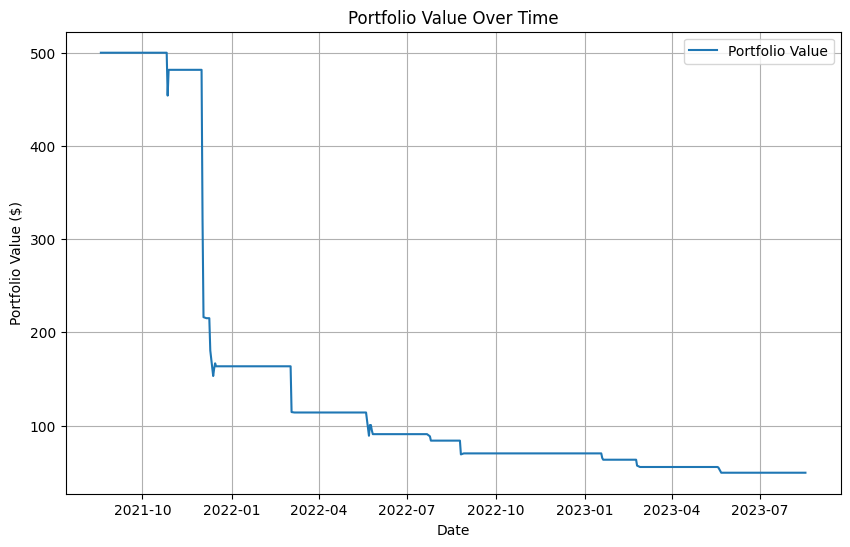

In [87]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download historical data using yfinance
history = yf.Ticker(stock_symbol)
stock_data = history.history(period='2y',interval='1h')

# Assuming 'd' is the DataFrame containing historical stock data
d = data.copy()

initial_capital = 5000
s = 0  # Stocks held
b = initial_capital  # Capital invested
bf = 0  # Buy flag
counter = 0  # Counter for successful trades
good1 = 0  # Counter for good trades
portfolio = []  # Portfolio value over time

for i in range(1, len(d)):
    if s > 0 or bf:
        if (d.iloc[i].High - d.iloc[i - 1].Close) / d.iloc[i - 1].Close > 0.01:
            b = s * d.iloc[i - 1].Close * 1.01 * 0.998
            good1 += 1
        else:
            b = s * d.iloc[i].Close * 0.998
        s = 0
        bf = 0
    if b > 0:
        if (d.iloc[i].Close - d.iloc[i - 1].Low) / d.iloc[i - 1].Close > 0.01:
            s = b / (d.iloc[i].Close * 0.99) * 0.998
            b = 0
            counter += 1
            bf = 1
    portfolio_value = s * d.iloc[i].Close + b
    portfolio.append(portfolio_value)

# Add the final portfolio value after the loop
portfolio.append(s * d.iloc[-1].Close + b)

# Print results
print("Number of successful trades:", counter)
print("Number of good trades:", good1)

# Create a DataFrame to hold portfolio values
portfolio_df = pd.DataFrame({'Date': d.index, 'Portfolio Value': portfolio})
portfolio_df.set_index('Date', inplace=True)

# Plot portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(portfolio_df.index, portfolio_df['Portfolio Value'], label='Portfolio Value')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.title('Portfolio Value Over Time')
plt.legend()
plt.grid()
plt.show()


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

def backtest(stock_symbol, period='1w'):
    # Download historical data using yfinance
    history = yf.Ticker(stock_symbol)
    data = history.history(period=period)#,interval='1h')

    # Assuming 'd' is the DataFrame containing historical stock data
    d = data.copy()

    initial_capital = 500
    s = 0  # Stocks held
    b = initial_capital  # Capital invested
    bf = 0  # Buy flag
    counter = 0  # Counter for successful trades
    good1 = 0  # Counter for good trades
    portfolio = []  # Portfolio value over time

    for i in range(len(d)-2):
        if s > 0 or bf:
            if (d.iloc[i].High - d.iloc[i-1].Open) / d.iloc[i-1].Open > 0.02:
                b = s * d.iloc[i-1].Open * 1.01 * 0.998
                # print('ok')
            else:
                b = s * d.iloc[i].Close *0.998* 0.998
            s = 0
            bf = 0
        if b > 0 and (d.iloc[i].Open - d.iloc[i].Low) / d.iloc[i].Open > 0.1:
            s = b / (d.iloc[i].Open * 0.99) * 0.998
            b = 0
            counter += 1
            bf = 1

        portfolio_value = s * d.iloc[i+2].Close + b
        portfolio.append(portfolio_value)

    # Add the final portfolio value after the loop
    portfolio.append(s * d.iloc[-1].Close + b)

    # Print results
    print("Number of successful trades:", counter)
    print("Number of good trades:", good1)

    # Create a DataFrame to hold portfolio values
    portfolio_df = pd.DataFrame({'Date': d.index[1:], 'Portfolio Value': portfolio})
    portfolio_df.set_index('Date', inplace=True)

    # Plot portfolio value over time
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_df.index, portfolio_df['Portfolio Value'], label='Portfolio Value')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value ($)')
    plt.title('Portfolio Value Over Time')
    plt.legend()
    plt.grid()
    plt.show()


stock_symbol = 'GRAB'
backtest('GRAB','2y')